In [1]:
import numpy as np
import mpmath 
import matplotlib.pyplot as plt
import math as mth
from scipy import linalg, signal, constants, optimize

In [2]:
data = np.loadtxt('rho_2dots_dt5e-5_fix.dat')
rho_00_dot1 = data[:,0]
rho_01_dot1 = data[:,1] + 1j*data[:,2]

rho_00_dot2 = data[:,4]
rho_01_dot2 = data[:,5] + 1j*data[:,6]

In [3]:
def get_uvw(rho_00,rho_01):
    u = 2*rho_01.real
    v = 2*rho_01.imag
    w = 1-2*rho_00
    return u,v,w

In [4]:
u1_elliot,v1_elliot,w1_elliot = get_uvw(rho_00_dot1,rho_01_dot1)
u2_elliot,v2_elliot,w2_elliot = get_uvw(rho_00_dot2,rho_01_dot2)

t_elliot = np.linspace(0,10,u1_elliot.size)

In [5]:
def compare_frequency_spectra_solutions(signal_t_1,signal_t_2,t,minimum_f=-t_elliot.size/2,maximum_f=t_elliot.size/2):
    #plots the freq spec for a given signal.  minimum_f and maximum_f must be in Hz. signal is the variable name
    stop_time = t[-1]
    dt = stop_time/t.size
    
    Signal_w_1 = np.fft.fftshift(np.fft.fft(signal_t_1))
    Signal_w_2 = np.fft.fftshift(np.fft.fft(signal_t_2))
    freq = np.fft.fftshift(np.fft.fftfreq(signal_t_1.size,dt))
    
    min_nfreq = np.argmin(abs(minimum_f - freq))
    max_nfreq = np.argmin(abs(maximum_f - freq))
    
    plt.figure()
    plt.semilogy(freq[min_nfreq:max_nfreq],abs(Signal_w_1)[min_nfreq:max_nfreq],label='Chad Guess')
    
    plt.semilogy(freq[min_nfreq:max_nfreq],abs(Signal_w_2)[min_nfreq:max_nfreq],label='Elliot Solution')
    plt.legend()
    plt.grid()
    plt.xlabel('Linear Frequency')
    plt.ylabel('|Magnitude|')
    plt.show()
    
#     plt.figure()
#     plt.plot(freq[min_nfreq:max_nfreq],np.angle(Signal_w,deg=True)[min_nfreq:max_nfreq])
#     plt.ylabel('Phase (degrees)')
#     plt.xlabel('Linear Frequency')
#     plt.show()

In [6]:
#Define Constants

#Transient Parameters
omega_0 = 2278.9013 # in rad/picosecond
period = 2*np.pi/omega_0
f0 = omega_0 / (2*np.pi)

stop_time = 10 #in picoseconds

#Dot parameters
sigma = 2278.9013
t0 = 0.0
hbar = 0.65821193
T1 = 1e6
T2 = 2e6

#Misc Parameters
x_hat = np.array([1,0,0])
r_hat_dot1 = np.array([0,-1,0])
r_hat_dot2 = np.array([0,1,0])

c0 = 299.792458 #um/ps
mu0 = 2.0133545e-04
eps0 = 1/(mu0*c0**2)
R = 0.0035
r_hat = np.array([0,1,0],dtype=float)
d = 5.2917721e-4
d_vector = d*x_hat
d_vector = d_vector[:,np.newaxis]

E0 = 1558.8929

#omega_r = d*E0/hbar #+ E_rad*5.2917721e-4/hbar 
f_r = 2.2669
omega_r = 2*np.pi*f_r

In [7]:
#Multitone HB parameters
# Find frequencies of interest for solution
B = 3
m = np.arange(B + 1)
n = np.arange(-B,B+1)

m,n = np.meshgrid(m,n)
mn_sum_abs = abs(m) + abs(n)
mn = mn_sum_abs<=B
m = m[mn]
n = n[mn]

omegas = np.unique(np.ndarray.flatten(m*omega_0 + n*omega_r))

In [8]:
#Add delta omega to frequencies of interest
C = 1
delta_f = 1
delta_omega = 2*np.pi*delta_f
l = np.arange(-C,C+1)

delta_omegas = l*delta_omega

omegas,delta_omegas = np.meshgrid(omegas,delta_omegas)
omega_k = omegas + delta_omegas

omega_k = np.unique(np.ndarray.flatten(omega_k))

#Remove negative frequencies for real signals 
omega_k = omega_k[omega_k>=0]
omega_k = np.sort(omega_k)

num_frequencies = omega_k.size
num_coefficients = 2*num_frequencies - 1

print('Solving',num_frequencies,'frequencies')

Solving 38 frequencies


In [9]:
def get_gamma(t):
    #Creates a matrix of trigonometric basis functions
    return np.hstack((np.cos(omega_k*t[:,np.newaxis]),np.sin(omega_k[1:]*t[:,np.newaxis])))

In [10]:
def get_gamma_t0(t0):
    #Creates a matrix of trigonometric basis functions evaluated at an instant in time, t0
    #Used for enforcing initial conditions in the Newton Solver
    return np.hstack((np.cos(omega_k*t0),np.sin(omega_k[1:]*t0)))

In [11]:
def get_gamma_prime(t):
    #Creates a matrix of derivatives of trig basis functions
    return np.hstack((-omega_k*np.sin(omega_k*t[:,np.newaxis]),omega_k[1:]*np.cos(omega_k[1:]*t[:,np.newaxis])))

In [12]:
def get_gamma_double_prime(t):
    #Second derivative matrix
    return np.hstack((-omega_k**2*np.cos(omega_k*t[:,np.newaxis]),-omega_k[1:]**2*np.sin(omega_k[1:]*t[:,np.newaxis])))

In [13]:
def get_rhos(u,v,w):
    rho_00 = 0.5 - 0.5*w
    rho_01 = 0.5*u + 0.5j*v
    return rho_00, rho_01

In [14]:
def get_P(u_coeff,t):
    #Evaluates the polarization
    delay = t - (R/c0)
    gamma_delay = get_gamma(delay)
    u_delay = gamma_delay@u_coeff
    P = (u_delay.real)*d_vector
    return P

In [15]:
def get_P_prime(u_coeff,t):
    delay = t - (R/c0)
    gamma_prime_delay = get_gamma_prime(delay)
    u_prime_delay = gamma_prime_delay@u_coeff
    P_prime = (u_prime_delay.real)*d_vector
    
    return P_prime

In [16]:
def get_P_doubleprime(u_coeff,t):
    delay = t - (R/c0)
    gamma_doubleprime = get_gamma_double_prime(delay)
    u_doubleprime_delay = gamma_doubleprime@u_coeff
    P_doubleprime = (u_doubleprime_delay.real)*d_vector
    
    return P_doubleprime

In [17]:
def get_E_rad(u_coeff,v_coeff,w_coeff,t,r_hat):
    #Evaluates the radiation field from one dot onto another.  In the 2-dot case R is a constant for both dots.
    P = get_P(u_coeff,t)
    P_prime = get_P_prime(u_coeff,t)
    P_doubleprime = get_P_doubleprime(u_coeff,t)
    
    I = np.eye(3)
    
    E_rad = np.dot(I - np.outer(r_hat,r_hat),P_doubleprime)/(R*c0**2)
    
    E_rad += np.dot(I-3*np.outer(r_hat,r_hat),P_prime)/(c0*R**2)

    E_rad += np.dot(I-3*np.outer(r_hat,r_hat),P)/(R**3)
    
    E_rad *= -1/(4*np.pi*eps0)
    
    return E_rad

In [18]:
def get_chi(t, Er):
    #Takes in a radiation field from a specific dot and returns chi for that dot.
    wave_vector = x_hat
    r = x_hat*0.0
    args = np.dot(wave_vector,r) - omega_0*(t-t0)
    
    #pulse = np.exp(omega_0*(t - t0)**2/(2*sigma**2))
    #pulse = 0
    pulse = 1
    El = (E0*np.cos(args)*pulse)*x_hat[:,np.newaxis]
    
    E = El + Er
    chi = np.dot(d_vector.T,E) / hbar
    
    return chi[0,:]

In [19]:
t_k = np.linspace(0,stop_time,num_coefficients - 1)

In [20]:
def plot_error(t,f1,f2,f3,f4,f5,f6):
    plt.figure()
    plt.semilogy(t,abs(f1),label='f1')
    plt.semilogy(t,abs(f2),label='f2')
    plt.semilogy(t,abs(f3),label='f3')
    plt.legend()
    plt.show()

In [21]:
def get_f(coefficients,t=t_k):
    #Takes in an array of Fourier coefficients for u,v,w for both dots and returns the error functions in time
    u1_coeff = coefficients[:num_coefficients]
    v1_coeff = coefficients[num_coefficients:2*num_coefficients]
    w1_coeff = coefficients[2*num_coefficients:3*num_coefficients]
    
    u2_coeff = coefficients[3*num_coefficients:4*num_coefficients]
    v2_coeff = coefficients[4*num_coefficients:5*num_coefficients]
    w2_coeff = coefficients[5*num_coefficients:]
    
    gamma_t = get_gamma(t)
    gamma_prime = get_gamma_prime(t)
    gamma_0 = get_gamma_t0(0)
    
    u1 = gamma_t@u1_coeff
    v1 = gamma_t@v1_coeff
    w1 = gamma_t@w1_coeff
    
    u1_prime = gamma_prime@u1_coeff
    v1_prime = gamma_prime@v1_coeff
    w1_prime = gamma_prime@w1_coeff
    
    u2 = gamma_t@u2_coeff
    v2 = gamma_t@v2_coeff
    w2 = gamma_t@w2_coeff
    
    u2_prime = gamma_prime@u2_coeff
    v2_prime = gamma_prime@v2_coeff
    w2_prime = gamma_prime@w2_coeff
     
    Er_dot1 = get_E_rad(u1_coeff,v1_coeff,w1_coeff,t,r_hat_dot1)
    Er_dot2 = get_E_rad(u2_coeff,v2_coeff,w2_coeff,t,r_hat_dot2)
    
    chi1 = get_chi(t,Er_dot2)
    chi2 = get_chi(t,Er_dot1)
    
    f1_dot1 = -omega_0*v1 - u1_prime
    f2_dot1 = omega_0*u1 - 2*chi1*w1 - v1_prime
    f3_dot1 = 2*chi1*v1 - w1_prime
    f4_dot1 = gamma_0@u1_coeff
    f5_dot1 = gamma_0@v1_coeff
    f6_dot1 = gamma_0@w1_coeff + 1
    
    f1_dot2 = -omega_0*v2 - u2_prime
    f2_dot2 = omega_0*u2 - 2*chi2*w2 - v2_prime
    f3_dot2 = 2*chi2*v2 - w2_prime
    f4_dot2 = gamma_0@u2_coeff
    f5_dot2 = gamma_0@v2_coeff
    f6_dot2 = gamma_0@w2_coeff + 1
    
    plot_error(t,f1_dot1,f2_dot1,f3_dot1,f4_dot1,f5_dot1,f6_dot1)
    #plot_error(t,f1_dot2,f2_dot2,f3_dot2,f4_dot2,f5_dot2,f6_dot2)
    
    fk_dot1 = np.hstack((f1_dot1,f2_dot1,f3_dot1,f4_dot1,f5_dot1,f6_dot1))
    fk_dot2 = np.hstack((f1_dot2,f2_dot2,f3_dot2,f4_dot2,f5_dot2,f6_dot2))
    
    return np.hstack((fk_dot1,fk_dot2))

In [22]:
#Creates initial guesses for u,v,w for both dots using least square approximation
gamma = get_gamma(t_elliot)
W = gamma.T@gamma
W_inv = linalg.inv(W)

u1_guess = W_inv@gamma.T@u1_elliot
v1_guess = W_inv@gamma.T@v1_elliot
w1_guess = W_inv@gamma.T@w1_elliot

u2_guess = W_inv@gamma.T@u2_elliot
v2_guess = W_inv@gamma.T@v2_elliot
w2_guess = W_inv@gamma.T@w2_elliot

coefficients_guess = np.hstack((u1_guess,v1_guess,w1_guess,u2_guess,v2_guess,w2_guess))

In [23]:
u1_guess = gamma@u1_guess
v1_guess = gamma@v1_guess
w1_guess = gamma@w1_guess

u2_guess = gamma@u2_guess
v2_guess = gamma@v2_guess
w2_guess = gamma@w2_guess

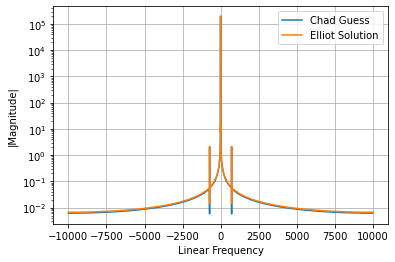

In [24]:
compare_frequency_spectra_solutions(w1_guess,w1_elliot,t_elliot)

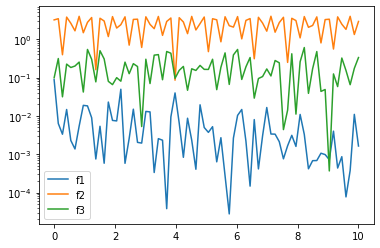

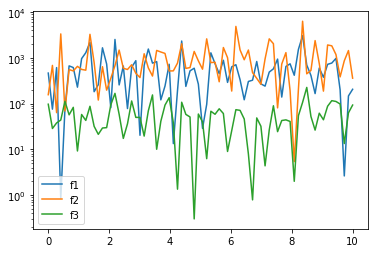

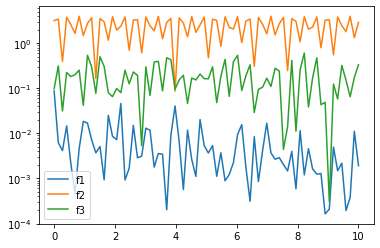

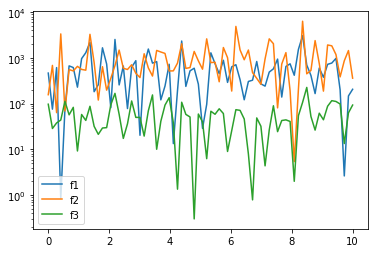

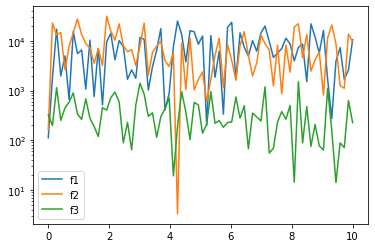

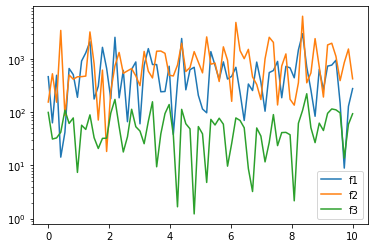

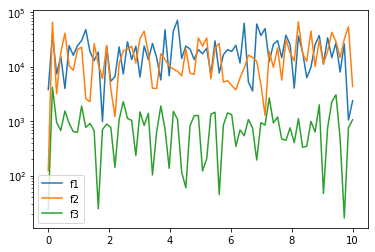

KeyboardInterrupt: 

In [26]:
#Solve system using Scipy Optimize Package
coeff = optimize.root(get_f,coefficients_guess,method='broyden1',options={'fatol':1e-1})

In [ ]:
u1_coeff = coeff[:num_coefficients]
v1_coeff = coeff[num_coefficients:2*num_coefficients]
w1_coeff = coeff[2*num_coefficients:3*num_coefficients]

u2_coeff = coeff[3*num_coefficients:4*num_coefficients]
v2_coeff = coeff[4*num_coefficients:5*num_coefficients]
w2_coeff = coeff[5*num_coefficients:]

u1 = gamma@u1_coeff
v1 = gamma@v1_coeff
w1 = gamma@w1_coeff

u2 = gamma@u2_coeff
v2 = gamma@v2_coeff
w2 = gamma@w2_coeff

In [ ]:
plt.figure()
plt.plot(t_elliot,u1_chad,label='u1 Guess')
plt.plot(t_elliot,u1_elliot,label='u1  Solution Elliot')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t_elliot,u1,label='Chad solution u1')
plt.plot(t_elliot,u1_elliot,label='Elliot solution u1')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(t_elliot,w1,label='Chad solution u1')
plt.plot(t_elliot,w1_elliot,label='Elliot solution u1')
plt.legend()
plt.show()